# Assignment 6

This assignment has weighting $3.5$.
The first question about clustering has 35%, and the second question about tiny image classification has 65%.

This is a challenging assignment, so I recommend you start early.

# Clustering for handwritten digits

Supervised learning requires labeled data, which can be expensive to acquire.
For example, a dataset with $N$ samples for classification will require manual labeling $N$ times.

One way to ameliorate this issue is to perform clustering of the raw data samples first, followed by manual inspection and labeling of only a few samples.
Recall that clustering is a form of non-supervised learning, so it does not require any class labels.

For example, say we are given a set of scanned hand-written digit images.
We can cluster them into 10 groups first, manually inspect and label a few images in each cluster, and propagate the label towards the rest of all (unlabeled) samples in each cluster.

The accuracy of such semi-automatic labeling depends on the accuracy of the clustering.
If each cluster (0 to 9) corresponds exactly to hand-written digits 0-9, we are fine.
Otherwise, we have some mis-labeled data.

The goal of this question is to exercise clustering of the scikit-learn digits dataset which has labels, so that we can verify our clustering accuracy.
The specifics are as follows.

$ \large You$ will be judged by the test accuracy of your code, and quality of descriptions of your method.
As a reference, a simple code I (Li-Yi) wrote can achieve about 78% accuracy. Try to beat it as much as you can.

$
\Large assessment:
\
1.Test\ accuracy.
\
2.Quality\ of\ description\ of\ method.
$

## Training and test data split

We will split the original dataset into training and test datasets
* training for building our clusters
* testing to see if the clusters can predict future data

## Accuracy
What is your clustering accuracy (comparing cluster labels with the ground truth labels), and what are the properties of mis-clustered samples?

## Data preprocessing
Would the original features (pixels) work well, or we need further processing like scaling/standardization or dimensionality-reduction, before clustering?

## Models and hyper-parameters

Let's focus on k-means clustering, as hierarchical and density-based clustering do not provide the predict() method under scikit-learn.

What is the best test performance you can achieve with which hyper-parameters (for k-means, standard scalar, and dimensionality reduction)?

### Hint
We have learned Pipeline and GridSearchCV for cross validation and hyper-parameter tuning.

In [4]:
%load_ext watermark
%watermark -a '' -u -d -v -p numpy,pandas,matplotlib,scipy,sklearn
%matplotlib inline

last updated: 2016-12-14 

CPython 3.5.2
IPython 4.2.0

numpy 1.11.1
pandas 0.18.1
matplotlib 1.5.1
scipy 0.18.0
sklearn 0.18


In [74]:
# Added version check for recent scikit-learn 0.18 checks
from distutils.version import LooseVersion as Version
from sklearn import __version__ as sklearn_version

## Load data

In [83]:
import numpy as np

from sklearn.datasets import load_digits
digits = load_digits()

X = digits.data # data in pixels
y = digits.target # digit labels

print(X.shape)
print(y.shape)

print(np.unique(y))

(1797, 64)
(1797,)
[0 1 2 3 4 5 6 7 8 9]


## Visualize data

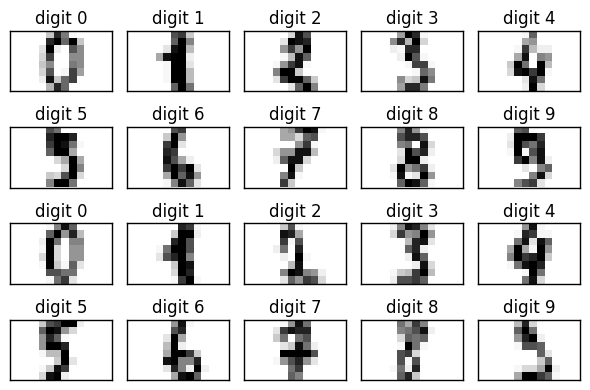

In [84]:
import matplotlib.pyplot as plt
import pylab as pl

num_rows = 4
num_cols = 5

fig, ax = plt.subplots(nrows=num_rows, ncols=num_cols, sharex=True, sharey=True)
ax = ax.flatten()
for index in range(num_rows*num_cols):
    img = digits.images[index]
    label = digits.target[index]
    ax[index].imshow(img, cmap='Greys', interpolation='nearest')
    ax[index].set_title('digit ' + str(label))

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

## Data sets: training versus test

In [85]:
if Version(sklearn_version) < '0.18':
    from sklearn.cross_validation import train_test_split
else:
    from sklearn.model_selection import train_test_split
    
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1)
print(len(X_train[0]))
num_training = y_train.shape[0]
num_test = y_test.shape[0]
print('training: ' + str(num_training) + ', test: ' + str(num_test))

64
training: 1437, test: 360


In [86]:
import numpy as np

# check to see if the data are well distributed among digits
for y in [y_train, y_test]:
    print(np.bincount(y))

[135 147 141 142 143 152 144 142 145 146]
[43 35 36 41 38 30 37 37 29 34]


## Answer

We first write a scoring function for clustering so that we can use for GridSearchCV.
Take a look at use_scorer under scikit learn.

In [155]:
from sklearn.metrics import accuracy_score, make_scorer
import itertools 
import numpy as np

'''The clustering_accuracy_score function is used to map the clustering label
    to the ground true label to get accuracy score. The algorithm first finds the maximum 
    frequence of the corresponding true label towards each class of clustering label and
     then map one clustering label to true label. The callable_clustering_accuracy_score function
      is to be used in gridSearchCV. ''' 

def clustering_accuracy_score(y_true, y_pred):
    # replace this with your code; note that y_pred is just cluster id, not digit id
    y_test = y_pred
    mapping_dic = {}
    for label in np.unique(y_test):
        label_dic = {}
        for i in range(len(y_test)):
            if y_test[i] == label and y_true[i] not in label_dic.keys():
                label_dic[y_true[i]] = 1
            elif y_test[i] == label and y_true[i] in label_dic.keys():
                label_dic[y_true[i]] += 1
        max_key = max(label_dic, key = lambda k: label_dic[k])
        mapping_dic[label] = max_key
    correct_count = 0
    for i in range(len(y_test)):
        if y_true[i] == mapping_dic[y_test[i]]:
            correct_count += 1          
    accuracy_rate = correct_count / len(y_test)
    return accuracy_rate

clustering_accuracy = make_scorer(clustering_accuracy_score)

def callable_clustering_accuracy_score(estimator, X_test, y_true):
    y_pred = estimator.fit_predict(X_test)
    return clustering_accuracy_score(y_true, y_pred)
#clustering_accuracy = make_scorer(clustering_accuracy_score)


In [156]:
"""Cluster_printer function aims to map clustering labels in clusters to 
    ground true labels. This is used for printing the false labeled images."""

def cluster_printer(estimator, X_train, y_train):
    mapping ={}
    y_pred = estimator.predict(X_train)
    predict_label_list = list(set(y_pred))
    for i in predict_label_list:
        array = y_train[y_pred == i]
        label = stats.mode(array).mode
        mapping[str(i)] = label[0]
    return mapping



Build a pipeline with standard scaler, PCA, and clustering.

In [157]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV

#pipe_line.get_params()
components_params = [2,3,4,5,7,10,15,30,40,60]


params = [{'scl__norm':np.array(['l1','l2','max']),
           'kernelpca__n_components':components_params,
           'kernelpca__kernel':['cosine'],
           'clf__n_clusters':[9,10,11,12,13,14,15],
           'clf__init':['k-means++']}]

# your code

Use GridSearchCV to tune hyper-parameters.

## Using first set of parameters to find the optimal one:

We aim to find the best set of parameters for 'cosine' kernel-pca.

In [136]:
# your code
scl = Normalizer()
kernelpca = KernelPCA()
clf = KMeans(random_state = 1)

pipe_line = Pipeline([('scl',scl),
                      ('kernelpca',kernelpca),
                      ('clf',clf)])
gridCV = GridSearchCV(estimator = pipe_line,
                      param_grid = params,
                      scoring = callable_clustering_accuracy_score,
                      cv = 10,
                      verbose = 1)

gridCV.fit(X_train,y_train)
#gridCV.cv_results_

best_model = gridCV.best_estimator_
best_model.fit(X_train,y_train)
y_cm = best_model.predict(X_test)


Fitting 10 folds for each of 210 candidates, totalling 2100 fits


[Parallel(n_jobs=1)]: Done 2100 out of 2100 | elapsed: 19.4min finished


In [152]:
print("+++++++++++++++++++++++++++++++++++++++++++")
print("The best estimator for cosine kernel is in below :")
print("+++++++++++++++++++++++++++++++++++++++++++")
print(gridCV.best_estimator_)


+++++++++++++++++++++++++++++++++++++++++++
The best estimator for cosine kernel is in below :
+++++++++++++++++++++++++++++++++++++++++++
Pipeline(steps=[('scl', Normalizer(copy=True, norm='l1')), ('kernelpca', KernelPCA(alpha=1.0, coef0=1, copy_X=True, degree=3, eigen_solver='auto',
     fit_inverse_transform=False, gamma=None, kernel='cosine',
     kernel_params=None, max_iter=None, n_components=15, n_jobs=1,
     random_state=None, remove_z...s=15, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=1, tol=0.0001, verbose=0))])


Accuracy_score : 0.9


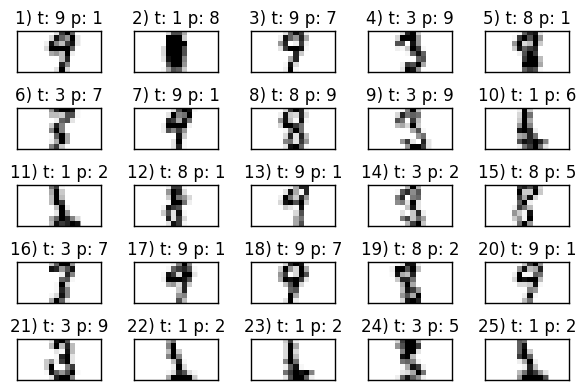

In [147]:
# your code
import matplotlib.pyplot as plt

mapping = cluster_printer(gridCV.best_estimator_, X_train, y_train)
y_test_pred = list(map(lambda x: mapping[str(x)], gridCV.best_estimator_.predict(X_test)))
y_test_pred = np.array(y_test_pred)

print("Accuracy_score :",accuracy_score(y_true=y_test, y_pred=y_test_pred))

miscl_img = X_test[y_test != y_test_pred][:25]
correct_lab = y_test[y_test != y_test_pred][:25]
miscl_lab = y_test_pred[y_test != y_test_pred][:25]

fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(25):
    img = miscl_img[i].reshape(8,8)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title('%d) t: %d p: %d' % (i+1, correct_lab[i], miscl_lab[i]))

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()


## The second set of training parameters:

We use radial basis function and polynomial functions to be the kernel for kernel-principle component 

analysis below. 


In [ ]:
params2 = [{'kernelpca__n_components':components_params,
           'kernelpca__kernel':['rbf','poly'],
           'kernelpca__degree':[3,6,9],
           'clf__n_clusters':[9,10,11,12,13,14,15],
           'clf__init':['k-means++']}]

In [54]:
scl = StandardScaler()
kernelpca = KernelPCA()
clf = KMeans(random_state = 1)
pipe_line2 = Pipeline([('scl',scl),
                      ('kernelpca',kernelpca),
                      ('clf',clf)])
gridCV2 = GridSearchCV(estimator = pipe_line2,
                      param_grid = params2,
                      scoring = callable_clustering_accuracy_score,
                      cv = 10,
                      verbose = 1)

gridCV2.fit(X_train,y_train)
#gridCV.cv_results_

best_model2 = gridCV2.best_estimator_
best_model2.fit(X_train,y_train)
y_cm = best_model2.predict(X_test)



Fitting 10 folds for each of 378 candidates, totalling 3780 fits


[Parallel(n_jobs=1)]: Done 3780 out of 3780 | elapsed: 42.1min finished


In [151]:
print("+++++++++++++++++++++++++++++++++++++++++++")
print("The best estimator for one of rbf&poly kernel is in below :")
print("+++++++++++++++++++++++++++++++++++++++++++")
print(gridCV2.best_estimator_)



+++++++++++++++++++++++++++++++++++++++++++
The best estimator for one of rbf&poly kernel is in below :
+++++++++++++++++++++++++++++++++++++++++++
Pipeline(steps=[('scl', StandardScaler(copy=True, with_mean=True, with_std=True)), ('kernelpca', KernelPCA(alpha=1.0, coef0=1, copy_X=True, degree=3, eigen_solver='auto',
     fit_inverse_transform=False, gamma=None, kernel='rbf',
     kernel_params=None, max_iter=None, n_components=40, n_jobs=1,
     random...s=15, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=1, tol=0.0001, verbose=0))])


Accuracy_score : 0.855555555556


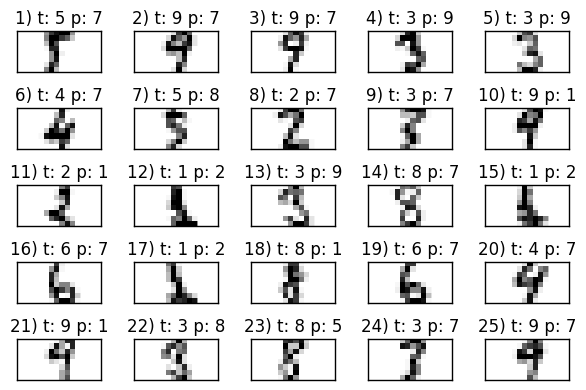

In [148]:
# your code
import matplotlib.pyplot as plt

mapping = cluster_printer(gridCV2.best_estimator_, X_train, y_train)
y_test_pred = list(map(lambda x: mapping[str(x)], gridCV2.best_estimator_.predict(X_test)))
y_test_pred = np.array(y_test_pred)

print("Accuracy_score :",accuracy_score(y_true=y_test, y_pred=y_test_pred))

miscl_img = X_test[y_test != y_test_pred][:25]
correct_lab = y_test[y_test != y_test_pred][:25]
miscl_lab = y_test_pred[y_test != y_test_pred][:25]

fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(25):
    img = miscl_img[i].reshape(8,8)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title('%d) t: %d p: %d' % (i+1, correct_lab[i], miscl_lab[i]))

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
# plt.savefig('./figures/mnist_miscl.png', dpi=300)
plt.show()


### Sigmoid kernel:
From the above two training processes, we can easily observe that the cosine kernel has a better 

performance in classifying the hand-written digits. We will use sigmoid kernel to test next

In [98]:
components_params = [i for i in range(2,20)]
params3 = [{'kernelpca__n_components':components_params,
           'kernelpca__kernel':['sigmoid'],
           'kernelpca__fit_inverse_transform':[False],
           'clf__n_clusters':[9,10,11,12,13,14,15],
           'clf__init':['k-means++']}]

In [99]:
scl = StandardScaler()
kernelpca = KernelPCA()
clf = KMeans(random_state = 1)
pipe_line3 = Pipeline([('scl',scl),
                      ('kernelpca',kernelpca),
                      ('clf',clf)])
gridCV3 = GridSearchCV(estimator = pipe_line3,
                      param_grid = params3,
                      scoring = callable_clustering_accuracy_score,
                      cv = 10,
                      verbose = 1)

gridCV3.fit(X_train,y_train)
#gridCV.cv_results_

best_model3 = gridCV3.best_estimator_
best_model3.fit(X_train,y_train)
y_cm = best_model3.predict(X_test)


Fitting 10 folds for each of 126 candidates, totalling 1260 fits


[Parallel(n_jobs=1)]: Done 1260 out of 1260 | elapsed: 18.0min finished


In [153]:
print("+++++++++++++++++++++++++++++++++++++++++++")
print("The best estimator for one of rbf&poly kernel is in below :")
print("+++++++++++++++++++++++++++++++++++++++++++")
print(gridCV3.best_estimator_)


+++++++++++++++++++++++++++++++++++++++++++
The best estimator for one of rbf&poly kernel is in below :
+++++++++++++++++++++++++++++++++++++++++++
Pipeline(steps=[('scl', StandardScaler(copy=True, with_mean=True, with_std=True)), ('kernelpca', KernelPCA(alpha=1.0, coef0=1, copy_X=True, degree=3, eigen_solver='auto',
     fit_inverse_transform=False, gamma=None, kernel='sigmoid',
     kernel_params=None, max_iter=None, n_components=16, n_jobs=1,
     ra...s=15, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=1, tol=0.0001, verbose=0))])


Visualize mis-clustered samples, and provide your explanation.

Accuracy_score : 0.869444444444


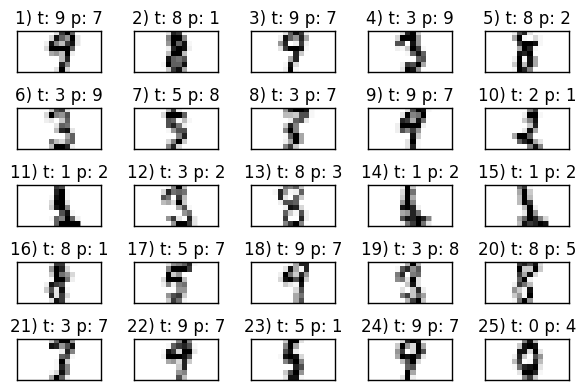

In [149]:
# your code
import matplotlib.pyplot as plt

mapping = cluster_printer(gridCV3.best_estimator_, X_train, y_train)
y_test_pred = list(map(lambda x: mapping[str(x)], gridCV3.best_estimator_.predict(X_test)))
y_test_pred = np.array(y_test_pred)

print("Accuracy_score :",accuracy_score(y_true=y_test, y_pred=y_test_pred))

miscl_img = X_test[y_test != y_test_pred][:25]
correct_lab = y_test[y_test != y_test_pred][:25]
miscl_lab = y_test_pred[y_test != y_test_pred][:25]

fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(25):
    img = miscl_img[i].reshape(8,8)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title('%d) t: %d p: %d' % (i+1, correct_lab[i], miscl_lab[i]))

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
# plt.savefig('./figures/mnist_miscl.png', dpi=300)
plt.show()


## GridSearchCV without pca

 Since we can simply check the data set is not linearly separable, we use kernel-PCA instead of PCA
 
 to do the feature reduction. So we don't tune models using PCA in this question. Besides, clustering
 
is an unsupervised classification algorithm and we can't use LDA in this situation. In below, we will 

do our training without using pca and kernel-pca. 

In [130]:
params4 = [{'clf__n_clusters':[9,10,11,12,13,14,15],
            'clf__init':['k-means++'],
            'clf__n_init':[i for i in range(5,15)],
            'clf__algorithm':['auto','full','elkan']}]

In [131]:
scl = StandardScaler()
kernelpca = KernelPCA()
clf = KMeans(random_state = 1)
pipe_line4 = Pipeline([('scl',scl),
                      ('clf',clf)])

gridCV4 = GridSearchCV(estimator = pipe_line4,
                      param_grid = params4,
                      scoring = callable_clustering_accuracy_score,
                      cv = 10,
                      verbose = 1)
gridCV4.fit(X_train,y_train)
#gridCV.cv_results_

best_model4 = gridCV4.best_estimator_
best_model4.fit(X_train,y_train)
y_cm = best_model4.predict(X_test)


Fitting 10 folds for each of 210 candidates, totalling 2100 fits


[Parallel(n_jobs=1)]: Done 2100 out of 2100 | elapsed: 14.8min finished


In [154]:
print("+++++++++++++++++++++++++++++++++++++++++++")
print("The best estimator for one of rbf&poly kernel is in below :")
print("+++++++++++++++++++++++++++++++++++++++++++")
print(gridCV4.best_estimator_)



+++++++++++++++++++++++++++++++++++++++++++
The best estimator for one of rbf&poly kernel is in below :
+++++++++++++++++++++++++++++++++++++++++++
Pipeline(steps=[('scl', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=14, n_init=6, n_jobs=1, precompute_distances='auto',
    random_state=1, tol=0.0001, verbose=0))])


Accuracy_score : 0.769444444444


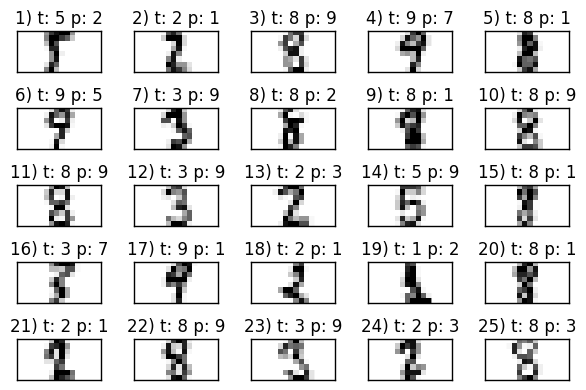

In [150]:
# your code
import matplotlib.pyplot as plt

mapping = cluster_printer(gridCV4.best_estimator_, X_train, y_train)
y_test_pred = list(map(lambda x: mapping[str(x)], gridCV4.best_estimator_.predict(X_test)))
y_test_pred = np.array(y_test_pred)

print("Accuracy_score :",accuracy_score(y_true=y_test, y_pred=y_test_pred))

miscl_img = X_test[y_test != y_test_pred][:25]
correct_lab = y_test[y_test != y_test_pred][:25]
miscl_lab = y_test_pred[y_test != y_test_pred][:25]

fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(25):
    img = miscl_img[i].reshape(8,8)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title('%d) t: %d p: %d' % (i+1, correct_lab[i], miscl_lab[i]))

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
# plt.savefig('./figures/mnist_miscl.png', dpi=300)
plt.show()


### Explanation for the training process.
After parameter tuning, we find that non-linear kernel principle component analysis such as cosine 

kernel have a better performance. The reason is that the pixels or the features of the hand-written 

digits are not linearly seperable. So if we use pca to deal with it, the accuracy score is not high.

Besides, one thing that surprises us is that the the best number of clusters is higher than the number

of classes, 10. We guess that this may result from the difference between the formal digits and hand-

written digits since some hand-written digits are even difficult to be classified even from human eyes 

and hence misleads the learning process. The distinction in number of true classes and predicted 

clusters will not effect our training process by the designed clustering algorithm, which is 

elaborated in the clustering_accuracy_score function cell above.

Furthermore, if we choose not to use dimension reduction process, the classification performance is 

not as good as using kernel-pca. Besides, using normalizer method is better than standardscaler method

in our best model tuning and the best model can achieve 90% accuracy rate and the corresponding 

preprocessing methid, kernels and hyper-parameters are listed in above. The comparison training sets

are also listed above.




The pictures that are not classified well have a bad hand-written shapes. It's even hard for us to classify it with eyes.

# Tiny image classification

We will use the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) for image object recognition.
The dataset consists of 50000 training samples and 10000 test samples in 10 different classes (airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck; see the link above for more information).
The goal is to maximize the accuracy of your classifier on the test dataset after being optimized via the training dataset.

You can use any learning models (supervised or unsupervised) or optimization methods (e.g. search methods for hyper-parameters).
The only requirement is that your code can run inside an ipynb file, as usual.
Please provide a description of your method, in addition to the code.
Your answer will be evaluated not only on the test accuracy but also on the creativity of your methodology and the quality of your explanation/description.

## Sample code to get you started

This is a difficult classification task.
A sample code below, based on a simple fully connected neural network built via Keras, is provided below.
The test accuracy is about 43%.

In [ ]:
%load_ext watermark
%watermark -a '' -u -d -v -p numpy,keras

In [43]:
import keras
from keras.datasets import cifar10
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import SGD
import numpy as np
from sklearn.metrics import accuracy_score

# load data set
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

img_shape = X_train.shape[1:] # [num_rows, num_cols, num_channels]
num_img_pixels = np.prod(img_shape)
num_training_samples = X_train.shape[0]
num_test_samples = X_test.shape[0]

nb_classes = np.sum(np.unique(y_train).shape)

print('image shape: ', img_shape)
print(X_train.shape[0], 'training samples')
print(X_test.shape[0], 'test samples')
print(nb_classes, 'classes')
print(num_img_pixels, " pixels")
# data processing

X_train = X_train.reshape(num_training_samples, num_img_pixels)
X_test = X_test.reshape(num_test_samples, num_img_pixels)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

#print("X_train : ",X_train )
#print("X_test : ",X_test)

# one hot encoding of labels
y_train_ohe = np_utils.to_categorical(y_train)
y_test_ohe = np_utils.to_categorical(y_test)

Using Theano backend.
ERROR (theano.sandbox.cuda): Failed to compile cuda_ndarray.cu: libcublas.so.8.0: cannot open shared object file: No such file or directory
ERROR:theano.sandbox.cuda:Failed to compile cuda_ndarray.cu: libcublas.so.8.0: cannot open shared object file: No such file or directory
WARNING (theano.sandbox.cuda): CUDA is installed, but device gpu0 is not available  (error: cuda unavailable)


image shape:  (3, 32, 32)
50000 training samples
10000 test samples
10 classes
3072  pixels


In [ ]:
# build a basic network


model = Sequential()

model.add(Dense(input_dim = num_img_pixels, 
                output_dim = 50, 
                init = 'uniform', 
                activation = 'tanh'))

model.add(Dense(output_dim = 50, 
                init = 'uniform', 
                activation = 'tanh'))

model.add(Dense(output_dim = nb_classes, 
                init = 'uniform', 
                activation = 'softmax'))

sgd = SGD(lr=0.001, decay=1e-7, momentum=.9)

model.compile(loss = 'categorical_crossentropy', 
              optimizer = sgd, 
              metrics = ["accuracy"])


# train

_ = model.fit(X_train, y_train_ohe, 
              nb_epoch = 5, 
              batch_size = 10, 
              verbose = True, # turn this on to visualize progress 
              validation_split = 0.1 # 10% of training data for validation per epoch
             )

# evaluate

y_train_pred = model.predict_classes(X_train, verbose=True)
print('First few predictions: ', y_train_pred[:3])
train_acc = accuracy_score(y_train, y_train_pred)
print('Training accuracy:', train_acc)

y_test_pred = model.predict_classes(X_test, verbose=True)
test_acc = accuracy_score(y_test, y_test_pred)
print('Test accuracy:', test_acc)


## Answer

### First head at beginning:
The neural network below is constructed based on the hint in the tutorial by

"Building powerful image classification models using very little data" , 

author: Francois Chollet. Link : https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html 

This tutorial gives me some elementary knowledge 

on how to construct a simple neural network scientifically and I choose to 

improve a basic structure designed below according to our question requirement.


In [44]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense


# the data, shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

# dimensions of our images.
img_width, img_height = 32, 32

#train_data_dir = 'data/train'
#validation_data_dir = 'data/validation'
batch_size = 30
nb_train_samples = 50000
nb_validation_samples = 10000
nb_epoch = 200


model = Sequential()
model.add(Convolution2D(32, 3, 3, border_mode = 'same' ,input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(32, 3, 3, border_mode = 'same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2),border_mode = 'same'))

model.add(Convolution2D(64, 3, 3, border_mode = 'same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2),border_mode = 'same'))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))
#Different learning rate with default parameter.
sgd = SGD(lr = 0.005, decay = 1e-6,momentum = 0.9,nesterov = True)
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])


X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

#set data_augmentation here:

data_augmentation = False

if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(X_train, Y_train,
              batch_size=batch_size,
              nb_epoch=nb_epoch,
              validation_data=(X_test, Y_test),
              shuffle=True)
else:
    print('Using real-time data augmentation.')

    # this will do preprocessing and realtime data augmentation
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

    # compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied)
    datagen.fit(X_train)
    print(X_train.shape)
    # fit the model on the batches generated by datagen.flow()
    model.fit_generator(datagen.flow(X_train, Y_train,
                        batch_size=batch_size),
                        samples_per_epoch=X_train.shape[0],
                        nb_epoch=nb_epoch,
                        validation_data=(X_test, Y_test))



X_train shape: (50000, 3, 32, 32)
50000 train samples
10000 test samples
Not using data augmentation.
Train on 50000 samples, validate on 10000 samples
Epoch 1/200
50000/50000 [==============================] - 60s - loss: 1.8762 - acc: 0.3023 - val_loss: 1.4740 - val_acc: 0.4744
Epoch 2/200
50000/50000 [==============================] - 58s - loss: 1.5026 - acc: 0.4567 - val_loss: 1.2690 - val_acc: 0.5430
Epoch 3/200
50000/50000 [==============================] - 56s - loss: 1.3412 - acc: 0.5218 - val_loss: 1.1245 - val_acc: 0.5970
Epoch 4/200
50000/50000 [==============================] - 56s - loss: 1.2253 - acc: 0.5647 - val_loss: 1.0574 - val_acc: 0.6334
Epoch 5/200
50000/50000 [==============================] - 58s - loss: 1.1377 - acc: 0.5978 - val_loss: 0.9936 - val_acc: 0.6589
Epoch 6/200
50000/50000 [==============================] - 67s - loss: 1.0622 - acc: 0.6250 - val_loss: 0.9421 - val_acc: 0.6683
Epoch 7/200
50000/50000 [==============================] - 64s - loss: 1.0

In [47]:
y_train_pred = model.predict_classes(X_train, verbose=True)
print('First few predictions: ', y_train_pred[:3])
#print(y_train,y_train_pred)

train_acc = accuracy_score(y_train, y_train_pred)
print('Training accuracy:', train_acc)

y_test_pred = model.predict_classes(X_test, verbose=True)
test_acc = accuracy_score(y_test, y_test_pred)
print('Test accuracy:', test_acc)


49984/50000 [============================>.] - ETA: 0sFirst few predictions:  [6 9 9]
Training accuracy: 0.94222
10000/10000 [==============================] - 3s     
Test accuracy: 0.7123


## Results and improvement:

As we can see from the above training example, The very high training accuracy doesn't correspond to a equally high 

test accuracy rate. It's caused by overfitting and we could improve our model by adding dropout layers, which are 

designed to promote this. Besides ,we choose to use data augmentation below and this will also help by making the 

same image a little bit different in each epoch in order to  make our training process more generalized. 

In [51]:
nb_epoch = 4
model2 = Sequential()

model2.add(Dropout(0.2,input_shape=X_train.shape[1:]))
model2.add(Convolution2D(32, 3, 3, border_mode = 'same'))
model2.add(Activation('relu'))
model2.add(Convolution2D(32,3,3))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Convolution2D(32, 3, 3, border_mode = 'same'))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2),border_mode = 'same'))

model2.add(Convolution2D(64, 3, 3, border_mode = 'same'))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2),border_mode = 'same'))

model2.add(Flatten())
model2.add(Dense(256))
model2.add(Activation('relu'))
model2.add(Dropout(0.5))
model2.add(Dense(nb_classes))
model2.add(Activation('sigmoid'))

sgd = SGD(lr = 0.005, decay = 1e-6,momentum = 0.9,nesterov = True)
model2.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

data_augmentation = True

if not data_augmentation:
    print('Not using data augmentation.')
    model2.fit(X_train, Y_train,
              batch_size=batch_size,
              nb_epoch=nb_epoch,
              validation_data=(X_test, Y_test),
              shuffle=True)
else:
    print('Using real-time data augmentation.')

    # this will do preprocessing and realtime data augmentation
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

    # compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied)
    datagen.fit(X_train)
    print(X_train.shape)
    # fit the model on the batches generated by datagen.flow()
    model2.fit_generator(datagen.flow(X_train, Y_train,
                        batch_size=batch_size),
                        samples_per_epoch=X_train.shape[0],
                        nb_epoch=nb_epoch,
                        validation_data=(X_test, Y_test))



Using real-time data augmentation.
(50000, 3, 32, 32)
Epoch 1/200
50000/50000 [==============================] - 87s - loss: 2.2112 - acc: 0.1709 - val_loss: 2.0959 - val_acc: 0.2299
Epoch 2/200
50000/50000 [==============================] - 79s - loss: 2.0147 - acc: 0.2509 - val_loss: 1.9154 - val_acc: 0.3158
Epoch 3/200
50000/50000 [==============================] - 79s - loss: 1.8850 - acc: 0.3117 - val_loss: 1.7768 - val_acc: 0.3741
Epoch 4/200
50000/50000 [==============================] - 76s - loss: 1.7516 - acc: 0.3626 - val_loss: 1.7474 - val_acc: 0.3794
Epoch 5/200
50000/50000 [==============================] - 76s - loss: 1.6528 - acc: 0.3988 - val_loss: 1.6373 - val_acc: 0.4180
Epoch 6/200
50000/50000 [==============================] - 76s - loss: 1.5882 - acc: 0.4250 - val_loss: 1.5027 - val_acc: 0.4679
Epoch 7/200
50000/50000 [==============================] - 77s - loss: 1.5459 - acc: 0.4412 - val_loss: 1.4583 - val_acc: 0.4966
Epoch 8/200
50000/50000 [==================

In [52]:
y_train_pred = model2.predict_classes(X_train, verbose=True)
print('First few predictions: ', y_train_pred[:3])
#print(y_train,y_train_pred)

train_acc = accuracy_score(y_train, y_train_pred)
print('Training accuracy:', train_acc)

y_test_pred = model2.predict_classes(X_test, verbose=True)
test_acc = accuracy_score(y_test, y_test_pred)
print('Test accuracy:', test_acc)



49984/50000 [============================>.] - ETA: 0sFirst few predictions:  [6 9 9]
Training accuracy: 0.76542
 9984/10000 [============================>.] - ETA: 0sTest accuracy: 0.7143


## Results and improvement:
We can see from the above improvement, the overfitting problem has been improved a lot. The training accuracy and 

the test accuracy has a smaller difference. However, our test accuracy is still not high and we should consider to 

complicate our neural network and to increase its complexity. We will add some convolution layers and increase the 

number of nodes in dense layer.     

In [61]:
nb_epoch = 200
model3 = Sequential()

model3.add(Dropout(0.2,input_shape=X_train.shape[1:]))
model3.add(Convolution2D(32, 3, 3, border_mode = 'same'))
model3.add(Activation('relu'))
model3.add(Convolution2D(32,3,3))
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))

model3.add(Convolution2D(64, 3, 3, border_mode = 'same'))
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size=(2, 2),border_mode = 'same'))

model3.add(Convolution2D(64, 3, 3, border_mode = 'same'))
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size=(2, 2),border_mode = 'same'))
model3.add(Dropout(0.25,input_shape=X_train.shape[1:]))


model3.add(Flatten())
model3.add(Dense(512))
model3.add(Activation('relu'))
model3.add(Dropout(0.5))
model3.add(Dense(nb_classes))
model3.add(Activation('softmax'))

sgd = SGD(lr = 0.007, decay = 1e-6,momentum = 0.9,nesterov = True)
model3.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

data_augmentation = True

if not data_augmentation:
    print('Not using data augmentation.')
    model3.fit(X_train, Y_train,
              batch_size=batch_size,
              nb_epoch=nb_epoch,
              validation_data=(X_test, Y_test),
              shuffle=True)
else:
    print('Using real-time data augmentation.')

    # this will do preprocessing and realtime data augmentation
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

    # compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied)
    datagen.fit(X_train)
    print(X_train.shape)
    # fit the model on the batches generated by datagen.flow()
    model3.fit_generator(datagen.flow(X_train, Y_train,
                        batch_size=batch_size),
                        samples_per_epoch=X_train.shape[0],
                        nb_epoch=nb_epoch,
                        validation_data=(X_test, Y_test))



Using real-time data augmentation.
(50000, 3, 32, 32)
Epoch 1/200
50000/50000 [==============================] - 157s - loss: 2.1398 - acc: 0.2018 - val_loss: 1.9085 - val_acc: 0.3139
Epoch 2/200
50000/50000 [==============================] - 151s - loss: 1.8601 - acc: 0.3188 - val_loss: 1.6145 - val_acc: 0.4054
Epoch 3/200
50000/50000 [==============================] - 155s - loss: 1.6615 - acc: 0.3874 - val_loss: 1.5082 - val_acc: 0.4596
Epoch 4/200
50000/50000 [==============================] - 154s - loss: 1.5511 - acc: 0.4298 - val_loss: 1.4148 - val_acc: 0.5076
Epoch 5/200
50000/50000 [==============================] - 154s - loss: 1.4609 - acc: 0.4687 - val_loss: 1.3035 - val_acc: 0.5358
Epoch 6/200
50000/50000 [==============================] - 154s - loss: 1.3899 - acc: 0.4990 - val_loss: 1.2255 - val_acc: 0.5633
Epoch 7/200
50000/50000 [==============================] - 158s - loss: 1.3230 - acc: 0.5246 - val_loss: 1.1637 - val_acc: 0.5900
Epoch 8/200
50000/50000 [===========

In [62]:
y_train_pred = model3.predict_classes(X_train, verbose=True)
print('First few predictions: ', y_train_pred[:3])
#print(y_train,y_train_pred)

train_acc = accuracy_score(y_train, y_train_pred)
print('Training accuracy:', train_acc)

y_test_pred = model3.predict_classes(X_test, verbose=True)
test_acc = accuracy_score(y_test, y_test_pred)
print('Test accuracy:', test_acc)



50000/50000 [==============================] - 41s    
First few predictions:  [6 9 9]
Training accuracy: 0.92994
10000/10000 [==============================] - 8s     
Test accuracy: 0.8639


## Your description
with the following main parts:

<dl>

<dt>Introduction</dt>
<dd>
At a high-level, what are the approaches you considered and why?
</dd>

<dt>Method</dt>
<dd>
Describe your entire pipeline, such as data-preprocessing, model selection, and hyper-parameter optpimization.
</dd>

<dt>Results</dt>
<dd>
Describe the experimental process you took to arrive at the solution.
For example:
(1) compare your approach against other approach(es) you have tried, as
well as the MLP baseline classifer.
(2) compare against different settings of model parameters, e.g. regularization type/strength, number of hidden units or structure of a neural network, types of kernel in a SVM, etc. 

<dt>Conclusion</dt>
<dd>
Summarize what you have learned from the experiments and discuss the limitations and potential future improvements of your current method.
</dd>

<dt>References</dt>
<dd>
Cite any publically available code, blog posts, research papers, etc. you used or got ideas from.
</dl>

#### Introduction:
At first, I choose to construct a neural network using sequential method in keras that is, a linear

stack of layers to achieve tiny image classification. The reason is that the images have comparatively

large amount of features, pixels. A simple classific classification algorithm or simple ensemble 

algorithm. e.g. SVM, Logistic regression may not be competent to achieve a high accuracy or at least, 

very inefficient to tune their hyper-parameters.

Hence, We choose to use neural network, which is convenient to use(lots of implemented libraries, 

APIs in keras) and also can achieve higher accuracy scores.  


#### Method:
We construct a 15-layer neural network with maximum width 64 nodes at first to train, which is 

inspired by an online tutorial and I have run it for several hours to get the initial result, which 

can achieve around 70 % accuracy for both training and testing. We want to find the potential reason 

for low score and improve the neural network by adding or deleting layers or nodes. Besides, we can 

adjust the density of it.   


#### Result:
The comparisons of hyper-parameters: hidden layers, hyper parameters are listed during the 

experiment process. 

#### Conclusion:

Through this experiment, I have learnt how to construct a tiny-image neural network from base to top 

and improve the accuracy rate from 70% both training and testing to around 93% training accuracy and 

87% testing accuracy. During the experiment, we have faced less fitting, overtting and finally find 

out ways (e.g. add convolution layers ,dense layer or add some dropout layers) to solve the 

corresponding problem. Neural network is extremply powerful but it's also very difficult to tune 

layers or other parameters. The limitation of this method is that you have to figure out the potential 

reason to cause the problem, which needs many experiences. The future improvement may happen in 

more advanced activation function and more advanced neural network model such as 

pulsed neural network. Besides due to the limitation of hardware, the training 

time is very long. Maybe specilized hardware could also be a potential future improvement for this

method to reduce training time.

#### Reference:

1. Francois Chollet.(2016 June)."Building powerful image classification models using very little data" .Link :https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html
